Final Project: Swati Akella, Thomas Hamnett, Changjing Zhao

Facial Keypoints Detection

In our project, we built a series of neural networks in order to predict facial kepoints in image data.  Our inspiration for our model progression came from Daniel Nouri's tutorial as linked to on the Kaggle competition page.  We differed notably from this tutorial, however; we used Tensorflow Keras and Colab with TPU accelerators.

Our general approach was as follows:
1. Process data, conduct EDA, and set baseline model with only 1 linear activation layer on full dataset with non-null records
2. Build model based on Dense layers only (1d image data)
3. Add Conv2D layers (2d transformation)
4. Add data augmentation by flipping random images and targets
5. Add Dropout to prevent overfitting
6. Add callback schedules to decrease learning rate and increase momentum across epochs
7. Tune hyperparameters for performance on model with full target data
8. Some target variables have much more non-null records; build specialist models groups of target variables with similar numbers of non-null records

This approach is detailed in the code below.

We first need some initial setup to run on Tensorflow/TPU/Colab.  Additionally, we'll import necessary packages for our models.

In [ ]:
# #Code runs on Tensorflow 2
# %tensorflow_version 2.x
# default version on Colab incompatible, need to revert to 2.0.0
!pip install --ignore-installed --upgrade tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 40kB/s 
     |████████████████████████████████| 2.4MB 42.3MB/s 
     |████████████████████████████████| 450kB 47.7MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 3.8MB 32.5MB/s 
     |████████████████████████████████| 112kB 60.3MB/s 
     |████████████████████████████████| 20.0MB 119kB/s 
     |████████████████████████████████| 1.3MB 36.6MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 2.9MB 38.0MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 583kB 46.1MB/s 
     |████████████████████████████████| 327kB 51.3MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 163kB 30.0MB/s 
    

In [ ]:
from __future__ import absolute_import, division, print_function, \
unicode_literals

import tensorflow as tf
import os

In [ ]:
#Check Version
tf.__version__

'2.0.0'

In [ ]:
# import packages and classes
import io
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, \
MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# One-time download of data from Kaggle
# !kaggle competitions download -c facial-keypoints-detection
# !unzip facial-keypoints-detection.zip
# !unzip training.zip
# !unzip test.zip

In [ ]:
# Using Google Colab, upload data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Connect to TPU cluster and set TPU strategy
tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
    tpu=tpu_address)
tf.config.experimental_connect_to_cluster(cluster_resolver)
tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# Initialize TPU system on cluster
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)

INFO:tensorflow:Initializing the TPU system: 10.22.61.90:8470


INFO:tensorflow:Initializing the TPU system: 10.22.61.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
# Check available devices (optional step)
tf.config.experimental_list_devices()

['/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_CPU:0',
 '/job:worker/replica:0/task:0/device:CPU:0',
 '/job:worker/replica:0/task:0/device:XLA_CPU:0',
 '/job:worker/replica:0/task:0/device:TPU:0',
 '/job:worker/replica:0/task:0/device:TPU:1',
 '/job:worker/replica:0/task:0/device:TPU:2',
 '/job:worker/replica:0/task:0/device:TPU:3',
 '/job:worker/replica:0/task:0/device:TPU:4',
 '/job:worker/replica:0/task:0/device:TPU:5',
 '/job:worker/replica:0/task:0/device:TPU:6',
 '/job:worker/replica:0/task:0/device:TPU:7',
 '/job:worker/replica:0/task:0/device:TPU_SYSTEM:0']

We'll next load the data, perform some preprocessing, and conduct EDA.

In [ ]:
# Load training and test data
train_data = pd.read_csv("/content/drive/My Drive/training.csv")
test_data = pd.read_csv("/content/drive/My Drive/test.csv")
id_lookup = pd.read_csv("/content/drive/My Drive/IdLookupTable.csv")

In [ ]:
## Check for null values
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:
# Remove data without complete records (for now)
train_dropna = train_data.dropna()

In [ ]:
# Preprocess data
# Separate x and y
def preprocess_inp(data, test=False):
    
    # Select Image column as input data
    data_x = data['Image']
    
    # Convert from string to numpy array
    data_x = data_x.apply(lambda pix: np.fromstring(pix, sep=' ')).to_numpy()

    # Set x vals (pixels) to range [0,1]
    data_x = np.divide(np.vstack(data_x), 255.)
    data_x = data_x.astype(np.float32)

    # Test data does not have target variables, return transformed input
    if test == True:
        return data_x
    
    # Preprocess taget data
    else:
        # Select all target data and convert to numpy array
        data_y = data[data.columns[:-1]].to_numpy()
        
        # Set y vals to range [-1, 1] (centered, scaled)
        data_y = np.divide(np.subtract(data_y, 48), 48.)
        data_y = data_y.astype(np.float32)
    
        # Return transformed input and target
        return data_x, data_y

In [ ]:
# Get preprocessed training data for complete records
train_x, train_y = preprocess_inp(train_dropna)

# Split train and dev sets
x_train, x_dev, y_train, y_dev = train_test_split(train_x, train_y,
                                                  test_size=0.2)

# Set 2d representation for pixels
X2d_train = x_train.reshape(-1,96,96,1)
X2d_dev = x_dev.reshape(-1,96,96,1)

In [ ]:
# Verify shape of train and dev data
print('X2 Train Data Shape: ', X2d_train.shape)
print('X2 Dev Data Shape: ', X2d_dev.shape)
print('y Train Data Shape: ', y_train.shape)
print('y Dev Data Shape: ', y_dev.shape)

X2 Train Data Shape:  (1712, 96, 96, 1)
X2 Dev Data Shape:  (428, 96, 96, 1)
y Train Data Shape:  (1712, 30)
y Dev Data Shape:  (428, 30)


In [ ]:
# Estimate RMSE (multiply by 48 to account for earlier scaling)
def RMSE(val_loss):
    return np.sqrt(val_loss) * 48

In [ ]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

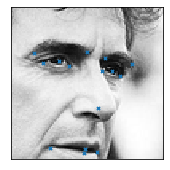

In [ ]:
# plot example image:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X2d_train[0], y_train[0], ax)
plt.show()

In [ ]:
train_data.iloc[0,:]

left_eye_center_x                                                      66.0336
left_eye_center_y                                                      39.0023
right_eye_center_x                                                      30.227
right_eye_center_y                                                     36.4217
left_eye_inner_corner_x                                                59.5821
left_eye_inner_corner_y                                                39.6474
left_eye_outer_corner_x                                                73.1303
left_eye_outer_corner_y                                                  39.97
right_eye_inner_corner_x                                               36.3566
right_eye_inner_corner_y                                               37.3894
right_eye_outer_corner_x                                               23.4529
right_eye_outer_corner_y                                               37.3894
left_eyebrow_inner_end_x                            

We will first train a baseline model in order to determine a benchmark for RMSE that we will look to improve upon.  In the baseline, we will use a 1d representation of input records and consturct a simple 1-layer model with a simple linear activation on the inputs to predict the targets.

We must use a linear activation layer in our final layer because we are compuitng continuous target variables (vs. labels).  We will calculate RMSE on the validation data (the 20% of data held out when we earlier split train and test data).


In [ ]:
def train_baseline_fn():
    # Convert the training inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    
    # Shuffle, repeat, and batch the examples
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(B_S, drop_remainder=True)
    #dataset = dataset.prefetch(-1)

    # Return the dataset
    return dataset

def val_baseline_fn():
    # Convert the validation inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((x_dev, y_dev))

    # Shuffle, repeat, and batch the examples
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(428, drop_remainder=True)

    # Return the dataset
    return dataset

def get_baseline():
    # Simple model with 1 layer (linear activation)
    inp = tf.keras.Input(
        name='inp', shape=(9216,), dtype=tf.float32)
    out = tf.keras.layers.Dense(30, activation='linear',
                                name='out')(inp)
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [ ]:
# Clear session in case of multiple runs (learning start from scratch)
tf.keras.backend.clear_session()

# use SGD with MSE loss for baseline
baseline = get_baseline()
baseline.compile(
    # SGD optimizer with default lr and high momentum
    optimizer=tf.keras.optimizers.SGD(learning_rate=.001,
                                        momentum=0.99,
                                        nesterov=True),
    loss='mean_squared_error',
    metrics=['accuracy'])
baseline.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 9216)]            0         
_________________________________________________________________
out (Dense)                  (None, 30)                276510    
Total params: 276,510
Trainable params: 276,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
B_S = 32
fitted_base = baseline.fit(train_baseline_fn(), epochs=100, verbose=1,
                   validation_data=val_baseline_fn(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S)))

Train for 54 steps, validate for 1 steps
Epoch 1/100
54/54 [==============================] - 1s 20ms/step - loss: 0.1089 - accuracy: 0.2708 - val_loss: 0.0433 - val_accuracy: 0.3154
Epoch 2/100
54/54 [==============================] - 1s 9ms/step - loss: 0.0348 - accuracy: 0.3779 - val_loss: 0.0301 - val_accuracy: 0.4206
Epoch 3/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0255 - accuracy: 0.4300 - val_loss: 0.0231 - val_accuracy: 0.4953
Epoch 4/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0200 - accuracy: 0.4699 - val_loss: 0.0204 - val_accuracy: 0.5187
Epoch 5/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0170 - accuracy: 0.5035 - val_loss: 0.0181 - val_accuracy: 0.4883
Epoch 6/100
54/54 [==============================] - 1s 9ms/step - loss: 0.0143 - accuracy: 0.5278 - val_loss: 0.0164 - val_accuracy: 0.5164
Epoch 7/100
54/54 [==============================] - 1s 9ms/step - loss: 0.0129 - accuracy: 0.5498 - val_loss: 

In [ ]:
# Calculate baseline RMSE (result approx 4)
RMSE(fitted_base.history['val_loss'][-1])

3.9136489832465915

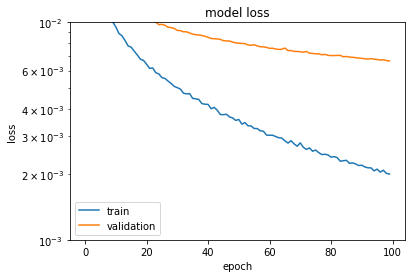

In [ ]:
# "Loss"
plt.plot(fitted_base.history['loss'])
plt.plot(fitted_base.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-3, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

We will now build our initial nerual network model with inner Dense layers on the 1d input data.  We use two Dense layers with relu activation before a final Dense linear activation layer (to predict conintuous variables).  

We will also try to use low lr and high momentum initially before tuning the hyperparameters later.

In [ ]:
def train_input_fn():
    # Convert the inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    
    # Shuffle, repeat, and batch the examples
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(B_S, drop_remainder=True)
    dataset = dataset.prefetch(-1)

    # Return the dataset
    return dataset

def val_input_fn():
    # Convert the inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((x_dev, y_dev))

    # Shuffle, repeat, and batch the examples
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(428, drop_remainder=True)

    # Return the dataset.
    return dataset

def get_model():
    inp = tf.keras.Input(
        name='inp', shape=(9216,), dtype=tf.float32)
    dense_1 = tf.keras.layers.Dense(128, activation='relu',
                                    name='dense_1')(inp)
    dense_2 = tf.keras.layers.Dense(64, activation='relu',
                                    name='dense_2')(dense_1)
    out = tf.keras.layers.Dense(30, activation='linear',
                                name='out')(dense_2)
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [ ]:
tf.keras.backend.clear_session()

with tpu_strategy.scope():  
    model = get_model()
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=.001,
                                          momentum=0.99,
                                          nesterov=True),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 9216)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
out (Dense)                  (None, 30)                1950      
Total params: 1,189,982
Trainable params: 1,189,982
Non-trainable params: 0
_________________________________________________________________


In [ ]:
B_S = 32
fitted = model.fit(train_input_fn(), epochs=500, verbose=1,
                   validation_data=val_input_fn(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S)))

Train on 54 steps, validate on 1 steps
Epoch 1/500
54/54 [==============================] - 5s 91ms/step - loss: 0.0708 - mean_squared_error: 0.0708 - accuracy: 0.1684 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_accuracy: 0.3762
Epoch 2/500
54/54 [==============================] - 1s 14ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - accuracy: 0.4566 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_accuracy: 0.5374
Epoch 3/500
54/54 [==============================] - 1s 14ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - accuracy: 0.5087 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_accuracy: 0.4463
Epoch 4/500
54/54 [==============================] - 1s 13ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - accuracy: 0.5775 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_accuracy: 0.5841
Epoch 5/500
54/54 [==============================] - 1s 13ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - accuracy: 0.6088 - val_loss: 0.01

In [ ]:
# Calculate RMSE
RMSE(fitted.history['val_loss'][-1])

2.302179983247675

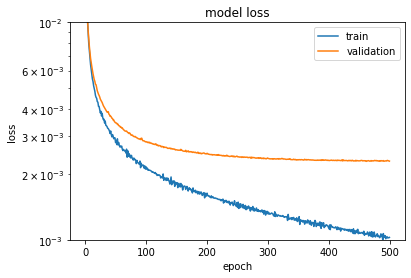

In [ ]:
# "Loss"
plt.plot(fitted.history['loss'])
plt.plot(fitted.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-3, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

We see our model begins overfitting early on in training, evidenced by the flattening of val loss across epochs while train loss continues to fall.  We will next try training on the 2d transformed input data (representing the 96 x 96 images).  This enables us to add 2d convulational layers to our model.  We will add three Conv2d layers, with strides, before Flattening and running three Dense layers (the last of which outputs 30 target variables using linear activation).

In [ ]:
def train_input_fn2():
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X2d_train, y_train))
    
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(B_S, drop_remainder=True)
    dataset = dataset.prefetch(-1)

    # Return the dataset.
    return dataset

def val_input_fn2():
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X2d_dev, y_dev))
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(428, drop_remainder=True)
    # Shuffle, repeat, and batch the examples.

    # Return the dataset.
    return dataset

def get_model2():
    inp = tf.keras.Input(
        name='inp', shape=(96,96,1), dtype=tf.float32)
    conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                    activation='relu', strides=(2,2),
                                    name='conv_1')(inp)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_2')(conv_1)
    conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_3')(conv_2)
    flat_1 = tf.keras.layers.Flatten()(conv_3)
    dense_1 = tf.keras.layers.Dense(512, activation='relu',
                                    name='dense_1')(flat_1)
    dense_2 = tf.keras.layers.Dense(512, activation='relu',
                                    name='dense_2')(dense_1)
    out = tf.keras.layers.Dense(30, activation='linear',
                                name='out')(dense_2)
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [ ]:
tf.keras.backend.clear_session()

with tpu_strategy.scope():  
    model2 = get_model2()
    model2.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=.001,
                                          momentum=0.99,
                                          nesterov=True),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 47, 47, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 23, 23, 64)        8256      
_________________________________________________________________
conv_3 (Conv2D)              (None, 11, 11, 128)       32896     
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               7930368   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656

In [ ]:
B_S = 32
fitted2 = model2.fit(train_input_fn2(), epochs=500, verbose=1,
                   validation_data=val_input_fn2(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S)))

Train on 54 steps, validate on 1 steps
Epoch 1/500
54/54 [==============================] - 6s 108ms/step - loss: 0.0878 - mean_squared_error: 0.0878 - accuracy: 0.5434 - val_loss: 0.0357 - val_mean_squared_error: 0.0356 - val_accuracy: 0.7336
Epoch 2/500
54/54 [==============================] - 1s 17ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - accuracy: 0.6979 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_accuracy: 0.7336
Epoch 3/500
54/54 [==============================] - 1s 18ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - accuracy: 0.6985 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_accuracy: 0.7336
Epoch 4/500
54/54 [==============================] - 1s 17ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - accuracy: 0.6968 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_accuracy: 0.7336
Epoch 5/500
54/54 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - accuracy: 0.7020 - val_loss: 0.0

In [ ]:
# Calculate RMSE
RMSE(fitted2.history['val_loss'][-1])

1.923315020456957

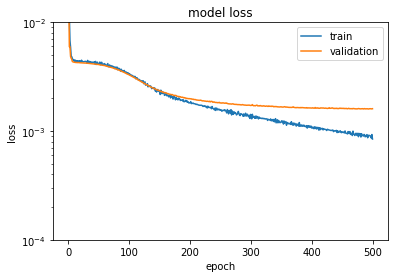

In [ ]:
# "Loss"
plt.plot(fitted2.history['loss'])
plt.plot(fitted2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-4, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

Again we see overfitting early on.  To address overfitting, we will look to augment the dataset.  We will do this by flipping random images and outputs (flipping horizontally across the y axis).  To flip our input, we simply reverse each row of the image.

To flip our output, we need two transformations.  First, we multiply all 'x' values of our target variables by -1 (reverse sign since we scaled target values to range of [-1, 1].  Next we need to swap any column that indicates a left/right endpoint.  For example, left_eye_center_x in column 0 needs to be swapped with right_eye_center_x in column 3 in order preserve the correct target variable being predicted.

Instead of directly augmenting the dataset (more records), we will randomly flip records in the dataset flow to get the benefit of data augmentation without the additional overhead of training on a larger dataset.

In [ ]:
# Testing flips of outputs

# Set dimensions of y
y0_dims = tf.shape(train_y)[0]
y1_dims = tf.shape(train_y)[1]

# Columns to be swapped
y1_all_lr = tf.constant([2, 3, 0, 1, 8, 9, 10, 11, 4, 5, 6, 7, 16, 17, 18,
               19, 12, 13, 14, 15, 20, 21, 24, 25, 22, 23, 26, 27, 28, 29],
               dtype=tf.int32)

# Multiply 'x' values by negative 1 (every other datapoint is an x value
# in the target data)
y_x_dim = int(y1_all_lr.shape[0]/2)
y_x_swap_rw = tf.tile([-1., 1.], [y_x_dim])

# Flip sign of output vals (testing on one record)
flipped_y = tf.multiply(y_train[0], y_x_swap_rw)

# Create tesnor with row #s for each output
y0_indices = tf.reshape(tf.range(0, limit=y0_dims), [y0_dims, 1])
y0_indices = tf.tile(y0_indices, [1, y1_dims])

# Create tensor with left/right swaps for each output
y1_indices = y1_all_lr
y1_indices = tf.reshape(y1_indices, [y1_dims, 1])

# Set output shape
out_shape = tf.shape(y_train[0])

# Create tensor with left/right swapped output vals
flipped_y = tf.scatter_nd(y1_indices, flipped_y, out_shape)

# Flip x on example image
flipped_x = tf.reverse(X2d_train[0], [1])

# print flipped and original first record to validate
print(flipped_y)
print(y_train[0])

tf.Tensor(
[ 0.41363636 -0.20660909 -0.3989091  -0.19848363  0.28363636 -0.18223272
  0.54365456 -0.18223272 -0.27703637 -0.19035818 -0.5451818  -0.17410545
  0.21863636 -0.36099455  0.6817818  -0.36912    -0.16327272 -0.33661819
 -0.65894544 -0.36099455 -0.01701818  0.1509091   0.29176363  0.61407274
 -0.31765455  0.61407274  0.00736364  0.4922      0.00736364  0.8090909 ], shape=(30,), dtype=float32)
[ 0.3989091  -0.19848363 -0.41363636 -0.20660909  0.27703637 -0.19035818
  0.5451818  -0.17410545 -0.28363636 -0.18223272 -0.54365456 -0.18223272
  0.16327272 -0.33661819  0.65894544 -0.36099455 -0.21863636 -0.36099455
 -0.6817818  -0.36912     0.01701818  0.1509091   0.31765455  0.61407274
 -0.29176363  0.61407274 -0.00736364  0.4922     -0.00736364  0.8090909 ]


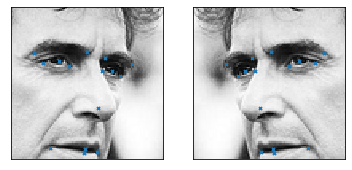

In [ ]:
# plot two images:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X2d_train[0], y_train[0], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(flipped_x.numpy(), flipped_y.numpy(), ax)
plt.show()

We will now implement flips as a tensorflow function that can be used in our Dataset flow

In [ ]:
# left and right features that need to be flipped
# [(0, 2), (1, 3), (4, 8), (5, 9), (6, 10), (7, 11), (12, 16), 
#  (13, 17), (14, 18), (15, 19), (22, 24), (23, 25)]

# Reassign left and right features
y1_all_lr = tf.constant([2, 3, 0, 1, 8, 9, 10, 11, 4, 5, 6, 7, 16, 17, 18,
               19, 12, 13, 14, 15, 20, 21, 24, 25, 22, 23, 26, 27, 28, 29],
               dtype=tf.int32)

@tf.function
def _flips2(x, y):
    
    # Set random tensor of 0s and 1s for records to flip
    uniform_random = tf.round(tf.random.uniform([1], 0, 1.0,
                                               seed=None))
    
    # Randomly select records to flip
    if uniform_random > 0.5:
        # Flip image tensor
        x_out = tf.reverse(x, [1])
        
        # Flip target tensor
        y_x_dim = int(y1_all_lr.shape[0]/2)
        y_x_swap = tf.tile([-1., 1.], [y_x_dim])
        flipped_y = tf.multiply(y, y_x_swap)
        idx = tf.reshape(y1_all_lr, [y.shape[0], 1])
        out_shape = tf.shape(y)
        y_out = tf.scatter_nd(idx, flipped_y, out_shape)
    
    # For non-selected recods, return original
    else:
        x_out = x
        y_out = y

    return x_out, y_out

Add data augmentation to training (we also use autotune to optimize training)

In [ ]:
def train_input_fn3():

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X2d_train, y_train))
    dataset = dataset.cache()
    
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.map(map_func = _flips2, 
                          num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(B_S, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    # Return the dataset.
    return dataset

def val_input_fn3():
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X2d_dev, y_dev))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(428, drop_remainder=True)

    # Return the dataset.
    return dataset

def get_model3():
    inp = tf.keras.Input(
        name='inp', shape=(96,96,1), dtype=tf.float32)
    conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                    activation='relu', strides=(2,2),
                                    name='conv_1')(inp)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_2')(conv_1)
    conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_3')(conv_2)
    flat_1 = tf.keras.layers.Flatten()(conv_3)
    dense_1 = tf.keras.layers.Dense(512, activation='relu',
                                    name='dense_1')(flat_1)
    dense_2 = tf.keras.layers.Dense(512, activation='relu',
                                    name='dense_2')(dense_1)
    out = tf.keras.layers.Dense(30, activation='linear',
                                name='out')(dense_2)
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [ ]:
tf.keras.backend.clear_session()

with tpu_strategy.scope():  
    model3 = get_model3()
    model3.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=.001,
                                            momentum=0.99,
                                            nesterov=True),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 47, 47, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 23, 23, 64)        8256      
_________________________________________________________________
conv_3 (Conv2D)              (None, 11, 11, 128)       32896     
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               7930368   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656

In [ ]:
B_S = 32
y1_lr = y1_all_lr
fitted3 = model3.fit(train_input_fn3(), epochs=500, verbose=1,
                     validation_data=val_input_fn3(),
                     validation_steps=1,
                     steps_per_epoch=-(1712//-(B_S)))

Train on 54 steps, validate on 1 steps
Epoch 1/500
54/54 [==============================] - 6s 109ms/step - loss: 0.0953 - mean_squared_error: 0.0953 - accuracy: 0.4797 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_accuracy: 0.7336
Epoch 2/500
54/54 [==============================] - 1s 18ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - accuracy: 0.4821 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_accuracy: 0.2196
Epoch 3/500
54/54 [==============================] - 1s 17ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - accuracy: 0.2992 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_accuracy: 0.7336
Epoch 4/500
54/54 [==============================] - 1s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - accuracy: 0.6788 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_accuracy: 0.7336
Epoch 5/500
54/54 [==============================] - 1s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - accuracy: 0.6765 - val_loss: 0.0

In [ ]:
# Calculate baseline RMSE
RMSE(fitted3.history['val_loss'][-1])

1.9389926098593695

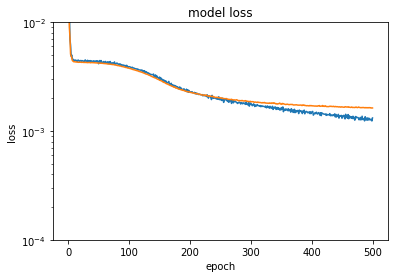

In [ ]:
# "Loss"
plt.plot(fitted3.history['loss'])
plt.plot(fitted3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-4, 1e-2)
#plt.legend(['train', 'validation'])
plt.show()

Our next step, to prevent overfitting, is to add Dropout layers that set every hidden unit is set to 0 with a probability of passed into the Dropout layer.  We will add 4 Dropout layers, one after each Conv2D layer and one after our the Dense layer before our output layer.

We also increased our learning rate and decreased momentum after observing that with Dropout, learning slowed greatly with low lr and high momentum.

In [ ]:
def get_model4():
    inp = tf.keras.Input(
        name='inp', shape=(96,96,1), dtype=tf.float32)
    conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                    activation='relu', strides=(2,2),
                                    name='conv_1')(inp)
    drop_1 = tf.keras.layers.Dropout(0.1, name='drop_1')(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_2')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.2, name='drop_2')(conv_2)
    conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_3')(drop_2)
    drop_3 = tf.keras.layers.Dropout(0.3, name='drop_3')(conv_3)
    flat_1 = tf.keras.layers.Flatten(name='flat_1')(drop_3)
    dense_1 = tf.keras.layers.Dense(1024, activation='relu',
                                    name='dense_1')(flat_1)
    drop_4 = tf.keras.layers.Dropout(0.5, name='drop_4')(dense_1)
    dense_2 = tf.keras.layers.Dense(1024, activation='relu',
                                    name='dense_2')(drop_4)
    out = tf.keras.layers.Dense(30, activation='linear',
                                name='out')(dense_2)
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [ ]:
tf.keras.backend.clear_session()

with tpu_strategy.scope():  
    model4 = get_model4()
    model4.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=.2,
                                            momentum=0.9,
                                            nesterov=True),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    model4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 47, 47, 32)        320       
_________________________________________________________________
drop_1 (Dropout)             (None, 47, 47, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 23, 23, 64)        8256      
_________________________________________________________________
drop_2 (Dropout)             (None, 23, 23, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 11, 11, 128)       32896     
_________________________________________________________________
drop_3 (Dropout)             (None, 11, 11, 128)       0     

In [ ]:
B_S = 32
fitted4 = model4.fit(train_input_fn3(), epochs=500, verbose=1,
                   validation_data=val_input_fn3(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S)))

Train on 54 steps, validate on 1 steps
Epoch 1/500
54/54 [==============================] - 6s 116ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - accuracy: 0.6175 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_accuracy: 0.7336
Epoch 2/500
54/54 [==============================] - 1s 19ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - accuracy: 0.6840 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_accuracy: 0.7336
Epoch 3/500
54/54 [==============================] - 1s 18ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - accuracy: 0.6719 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_accuracy: 0.7336
Epoch 4/500
54/54 [==============================] - 1s 19ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - accuracy: 0.6840 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_accuracy: 0.7336
Epoch 5/500
54/54 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - accuracy: 0.6753 - val_loss: 0.0

In [ ]:
# Calculate RMSE
RMSE(fitted4.history['val_loss'][-1])

1.423427478323705

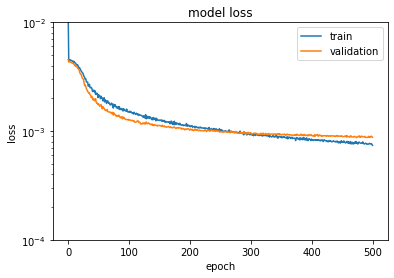

In [ ]:
# "Loss"
plt.plot(fitted4.history['loss'])
plt.plot(fitted4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-4, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

Droput has appeared to work well to address overfitting.  Next, we will use callbacks to decrease the learning rate and momentum over time in order to better tune the hyperparameters.

In [ ]:
# Momentum callback not natively implemented in tf.keras, so we created a 
# custom callback by looking at how other callbacks were implemented in
# tk.keras source code

class MomentumScheduler(tf.keras.callbacks.Callback):
  """Momentum scheduler which sets the momentum rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current momentum
          as inputs and returns a new momentum as output (float).
  """

  def __init__(self, schedule):
    super(MomentumScheduler, self).__init__()
    self.schedule = schedule

  def on_epoch_begin(self, epoch, logs=None):
    if not hasattr(self.model.optimizer, 'momentum'):
        raise ValueError('Optimizer must have a "momentum" attribute.')
    # Get the current momemtum from model's optimizer.
    momentum = float(tf.keras.backend.get_value(self.model.optimizer.momentum))
    # Call schedule function to get the scheduled momemtum.
    scheduled_momentum = self.schedule(epoch)
    # Set the value back to the optimizer before this epoch starts
    tf.keras.backend.set_value(self.model.optimizer.momentum,
                               scheduled_momentum)

In [ ]:
# Increase recursion limit to use larger number of epochs
import sys
sys.setrecursionlimit(20000)

After much trial and error, we found that a very high learning rate and low momentum worked best (decreasing over time) in minimizng RMSE on the validation set.  We also found that high Droput after each layer (0.5) worked best at preventing overfitting.

In [ ]:
def step_decay(epoch):
    return lr_sched[epoch - 1]

def step_mom_decay(epoch):
    return mom_sched[epoch - 1]

initial_lrate = 0.3
final_lrate = 0.1
EPOCHS = 10000
lr_sched = np.linspace(initial_lrate, final_lrate, EPOCHS)

initial_mom = 0.8
final_mom = 0.9
mom_sched = np.linspace(initial_mom, final_mom, EPOCHS)

lrate = LearningRateScheduler(step_decay)
estop = EarlyStopping(monitor='val_loss', patience=150)
mom = MomentumScheduler(step_mom_decay)
callbacks_list = [lrate, mom]#, estop, mom]

In [ ]:
def get_model_all():
    inp = tf.keras.Input(
        name='inp', shape=(96,96,1), dtype=tf.float32)
    conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                    activation='relu', strides=(2,2),
                                    name='conv_1')(inp)
    drop_1 = tf.keras.layers.Dropout(0.1, name='drop_1')(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_2')(conv_1)
    drop_2 = tf.keras.layers.Dropout(0.2, name='drop_2')(conv_2)
    conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_3')(drop_2)
    drop_3 = tf.keras.layers.Dropout(0.3, name='drop_3')(conv_3)
    # conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
    #                                 activation='relu', strides=(2,2),
    #                                 name='conv_4')(drop_3)
    # drop_4 = tf.keras.layers.Dropout(0.3, name='drop_4')(conv_4)
    flat_1 = tf.keras.layers.Flatten(name='flat_1')(drop_3)
    dense_1 = tf.keras.layers.Dense(1024, activation='relu',
                                    name='dense_1')(flat_1)
    drop_5 = tf.keras.layers.Dropout(0.5, name='drop_5')(dense_1)
    dense_2 = tf.keras.layers.Dense(1024, activation='relu',
                                    name='dense_2')(drop_5)
    drop_6 = tf.keras.layers.Dropout(0.5, name='drop_6')(dense_2)
    out = tf.keras.layers.Dense(30, activation='linear',
                                name='out')(drop_6)
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [ ]:
tf.keras.backend.clear_session()
#y1_lr = y1_all_lr

with tpu_strategy.scope():  
    model_all = get_model_all()
    model_all.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    model_all.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 47, 47, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 23, 23, 64)        8256      
_________________________________________________________________
drop_2 (Dropout)             (None, 23, 23, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 11, 11, 128)       32896     
_________________________________________________________________
drop_3 (Dropout)             (None, 11, 11, 128)       0         
_________________________________________________________________
flat_1 (Flatten)             (None, 15488)             0     

In [ ]:
B_S = 32

fitted_all = model_all.fit(train_input_fn3(), epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn3(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S))
                   ,callbacks=callbacks_list)

Train on 54 steps, validate on 1 steps
Epoch 1/10000
54/54 - 6s - loss: 0.0476 - mean_squared_error: 0.0476 - accuracy: 0.3108 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_accuracy: 0.7056
Epoch 2/10000
54/54 - 1s - loss: 0.0141 - mean_squared_error: 0.0141 - accuracy: 0.4676 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_accuracy: 0.7056
Epoch 3/10000
54/54 - 1s - loss: 0.0094 - mean_squared_error: 0.0094 - accuracy: 0.5480 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_accuracy: 0.7056
Epoch 4/10000
54/54 - 1s - loss: 0.0080 - mean_squared_error: 0.0080 - accuracy: 0.5914 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_accuracy: 0.7056
Epoch 5/10000
54/54 - 1s - loss: 0.0071 - mean_squared_error: 0.0071 - accuracy: 0.6047 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_accuracy: 0.7056
Epoch 6/10000
54/54 - 1s - loss: 0.0066 - mean_squared_error: 0.0066 - accuracy: 0.6007 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_

In [ ]:
# Calculate RMSE
RMSE(fitted_all.history['val_loss'][-1])

In [ ]:
# "Loss"
plt.plot(fitted_all.history['loss'])
plt.plot(fitted_all.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-4, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
# Save iniital model trained on complete records
model_all.save('/content/drive/My Drive/model_all.h5')

Finally, we will train a series of 'specialist' models on subsets of the original target values.  Earlier, we had dropped any record that was not complete.  However, we saw that some target variables had fewer null values, and we want to use the additional data we had previously dropped to improve model performance.

For these subsets where there are approx. the same number of non-null values, we will group these and train a new model.  Importantly, each of these new models will be initialized on the respective weights that we learned in the inital model we trained on the complete records so we are already starting from a model with learned weights.

Our goal with the specialist models is to take advantage of all the information possible in the training set and improve overall performance.

In [ ]:
# Load initial model
initial_model = tf.keras.models.load_model("/content/drive/My Drive/model_all.h5")

In [ ]:
# Create lookups for target features and columns numbers
row_feat = id_lookup.loc[id_lookup['ImageId'] == 1]
row_feat.set_index('RowId')
row_feat = row_feat[['FeatureName']]
row_feat = row_feat.to_dict('index')
row_feat = {row_feat[k]['FeatureName']: k  for k in row_feat.keys()}
row_feat

In [ ]:
# Create subsets of target data where number of non-null records are approx
# the same, and also create appropriate 'flips' on these subsets
idx_dict = {'eye_ctr': [0,4],
            'eye_crnr': [4,12],
            'eyebrow': [12,20],
            'nose': [20,22],
            'mouth_toplip': [22,28],
            'botlip': [28,30]}

y1_eye_ctr_lr = tf.constant([2, 3, 0, 1], dtype=tf.int32)
y1_eye_crnr_lr = tf.constant([4, 5, 6, 7, 0, 1, 2, 3], dtype=tf.int32)
y1_eyebrow_lr = tf.constant([4, 5, 6, 7, 0, 1, 2, 3], dtype=tf.int32)
y1_nose_lr = tf.constant([0, 1], dtype=tf.int32)
y1_mouth_toplip_lr = tf.constant([2, 3, 0, 1, 4, 5], dtype=tf.int32)
y1_botlip_lr = tf.constant([0, 1], dtype=tf.int32)

flip_dict = {'eye_ctr': y1_eye_ctr_lr,
             'eye_crnr': y1_eye_crnr_lr,
             'eyebrow': y1_eyebrow_lr,
             'nose': y1_nose_lr,
             'mouth_toplip': y1_mouth_toplip_lr,
             'botlip': y1_botlip_lr}

In [ ]:
# Modify flip function for subsets

tf.function
def _flips_spec(x, y, yflip_spec):
    
    # set random tensor of 0s and 1s for records to flip
    uniform_random = tf.round(tf.random.uniform([1], 0, 1.0,
                                               seed=None))
    
    if uniform_random > 0.5:
        # flip image tensor
        x_out = tf.reverse(x, [1])
        y_x_dim = int(yflip_spec.shape[0]/2)
        y_x_swap = tf.tile([-1., 1.], [y_x_dim])
        flipped_y = tf.multiply(y, y_x_swap)
        idx = tf.reshape(yflip_spec, [y.shape[0], 1])
        out_shape = tf.shape(y)
        y_out = tf.scatter_nd(idx, flipped_y, out_shape)
    
    else:
        x_out = x
        y_out = y

    return x_out, y_out

def train_input_fn_spec(x_train_cur, y_train_cur, y_flip):

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_train_cur, y_train_cur))
    dataset = dataset.cache()

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.map(map_func = lambda x, y: _flips_spec(x, y, y_flip),
                          num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(B_S, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    # Return the dataset.
    return dataset

def val_input_fn_spec(x_dev_cur, y_dev_cur):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_dev_cur, y_dev_cur))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(len(x_dev_cur), drop_remainder=True)

    # Return the dataset.
    return dataset

def get_model_spec(num_iv):
    inp = tf.keras.Input(name='inp', shape=(96,96,1), dtype=tf.float32)
    conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                    activation='relu', strides=(2,2),
                                    name='conv_1')(inp)
    drop_1 = tf.keras.layers.Dropout(0.1, name='drop_1')(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_2')(conv_1)
    drop_2 = tf.keras.layers.Dropout(0.2, name='drop_2')(conv_2)
    conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_3')(drop_2)
    drop_3 = tf.keras.layers.Dropout(0.3, name='drop_3')(conv_3)
    # conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
    #                                 activation='relu', strides=(2,2),
    #                                 name='conv_4')(drop_3)
    # drop_4 = tf.keras.layers.Dropout(0.3, name='drop_4')(conv_4)
    flat_1 = tf.keras.layers.Flatten(name='flat_1')(drop_3)
    dense_1 = tf.keras.layers.Dense(1024, activation='relu',
                                    name='dense_1')(flat_1)
    drop_5 = tf.keras.layers.Dropout(0.5, name='drop_5')(dense_1)
    dense_2 = tf.keras.layers.Dense(1024, activation='relu',
                                    name='dense_2')(drop_5)
    drop_6 = tf.keras.layers.Dropout(0.1, name='drop_6')(dense_2)
    out = tf.keras.layers.Dense(num_iv, activation='linear',
                                name='out')(drop_6)
    mod = tf.keras.Model(inputs=[inp], outputs=[out])
    return mod

In [ ]:
# Determine model hyperparameters for specialist models

def spec_params(spec):
    
    idx_start = idx_dict[spec][0]
    idx_end = idx_dict[spec][1]

    spec_cols = list(range(idx_start, idx_end)) + [30]

    train = train_data.iloc[:,spec_cols]
    train = train.dropna()
    train_x, train_y = preprocess_inp(train)
    x_train, x_dev, y_train, y_dev = train_test_split(train_x, train_y,
                                                test_size=0.2)
    X2d_train = x_train.reshape(-1,96,96,1)
    X2d_dev = x_dev.reshape(-1,96,96,1)

    weights = np.array(initial_model.get_weights())
    weights[10] = weights[10].T[idx_start:idx_end].T
    weights[11] = weights[11][idx_start:idx_end]
    weights = weights.tolist()

    y_flip = flip_dict[spec]
    n_iv = idx_end - idx_start
    return weights, X2d_train, y_train, X2d_dev, y_dev, y_flip, n_iv

In [ ]:
test_data.iloc[0,:]

In [ ]:
# Set callbacks for specialist models

initial_lrate = 0.3
final_lrate = 0.1
EPOCHS = 1000
lr_sched = np.linspace(initial_lrate, final_lrate, EPOCHS)

initial_mom = 0.8
final_mom = 0.9
mom_sched = np.linspace(initial_mom, final_mom, EPOCHS)

lrate = LearningRateScheduler(step_decay)
mom = MomentumScheduler(step_mom_decay)
estop = EarlyStopping(monitor='val_loss', patience=200)

spec_callbacks_list = [lrate, estop, mom]

In [ ]:
# Store hyperparameters as variables
spec_weights, spec_xtrain, spec_ytrain, spec_xdev, spec_ydev, \
    spec_yflip, spec_iv = spec_params('eye_ctr')

In [ ]:
tf.keras.backend.clear_session()

model_eye_ctr = get_model_spec(spec_iv)
model_eye_ctr.set_weights(spec_weights)
model_eye_ctr.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'accuracy'])
model_eye_ctr.summary()

In [ ]:
B_S = 128

fitted_eye_ctr = model_eye_ctr.fit(train_input_fn_spec(spec_xtrain,
                                                       spec_ytrain,
                                                       spec_yflip),
                            epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn_spec(spec_xdev,
                                                     spec_ydev),
                   validation_steps=1,
                   steps_per_epoch=-(len(spec_xtrain)//-(B_S)),
                   callbacks=spec_callbacks_list)

In [ ]:
# Save specialist model
model_eye_ctr.save('/content/drive/My Drive/model_eye_ctr.h5')

From here, we repeat the same process for each subset of target variables

In [ ]:
spec_weights, spec_xtrain, spec_ytrain, spec_xdev, spec_ydev, \
    spec_yflip, spec_iv = spec_params('eye_crnr')

In [ ]:
tf.keras.backend.clear_session()

model_eye_crnr = get_model_spec(spec_iv)
model_eye_crnr.set_weights(spec_weights)
model_eye_crnr.compile(
    optimizer=tf.keras.optimizers.SGD(momentum=0.9),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'accuracy'])
model_eye_crnr.summary()

In [ ]:
B_S = 128
#EPOCHS = 1000

fitted_eye_crnr = model_eye_crnr.fit(train_input_fn_spec(spec_xtrain,
                                                       spec_ytrain,
                                                       spec_yflip),
                            epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn_spec(spec_xdev,
                                                     spec_ydev),
                   validation_steps=1,
                   steps_per_epoch=-(len(spec_xtrain)//-(B_S)),
                   callbacks=spec_callbacks_list)

In [ ]:
model_eye_crnr.save('/content/drive/My Drive/model_eye_crnr.h5')

In [ ]:
spec_weights, spec_xtrain, spec_ytrain, spec_xdev, spec_ydev, \
    spec_yflip, spec_iv = spec_params('eyebrow')

In [ ]:
tf.keras.backend.clear_session()

model_eyebrow = get_model_spec(spec_iv)
model_eyebrow.set_weights(spec_weights)
model_eyebrow.compile(
    optimizer=tf.keras.optimizers.SGD(momentum=0.9),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'accuracy'])
model_eyebrow.summary()

In [ ]:
B_S = 128
EPOCHS = 1000

fitted_eyebrow = model_eyebrow.fit(train_input_fn_spec(spec_xtrain,
                                                       spec_ytrain,
                                                       spec_yflip),
                            epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn_spec(spec_xdev,
                                                     spec_ydev),
                   validation_steps=1,
                   steps_per_epoch=-(len(spec_xtrain)//-(B_S)),
                   callbacks=spec_callbacks_list)

In [ ]:
model_eyebrow.save('/content/drive/My Drive/model_eyebrow.h5')

In [ ]:
spec_weights, spec_xtrain, spec_ytrain, spec_xdev, spec_ydev, \
    spec_yflip, spec_iv = spec_params('nose')

In [ ]:
def step_decay_spec_nose(epoch):
    return lr_sched_nose[epoch - 1]
    
def step_mom_decay_spec_nose(epoch):
    return mom_sched_nose[epoch - 1]


In [ ]:
initial_lrate_nose = 0.2
final_lrate_nose = 0.1
EPOCHS = 1000
lr_sched_nose = np.linspace(initial_lrate, final_lrate, EPOCHS)

initial_mom_nose = 0.9
final_mom_nose = 0.95
mom_sched_nose = np.linspace(initial_mom, final_mom, EPOCHS)

lrate_nose = LearningRateScheduler(step_decay_spec_nose)
mom_nose = MomentumScheduler(step_mom_decay_spec_nose)
estop_nose = EarlyStopping(monitor='val_loss', patience=300,
                      restore_best_weights=True)

spec_callbacks_list_nose = [lrate_nose, estop_nose, mom_nose]

In [ ]:
def get_model_spec_nose(num_iv):
    inp = tf.keras.Input(name='inp', shape=(96,96,1), dtype=tf.float32)
    conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                    activation='relu', strides=(2,2),
                                    name='conv_1')(inp)
    drop_1 = tf.keras.layers.Dropout(0.1, name='drop_1')(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_2')(conv_1)
    drop_2 = tf.keras.layers.Dropout(0.2, name='drop_2')(conv_2)
    conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
                                    activation='relu', strides=(2,2),
                                    name='conv_3')(drop_2)
    drop_3 = tf.keras.layers.Dropout(0.3, name='drop_3')(conv_3)
    # conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2),
    #                                 activation='relu', strides=(2,2),
    #                                 name='conv_4')(drop_3)
    # drop_4 = tf.keras.layers.Dropout(0.3, name='drop_4')(conv_4)
    flat_1 = tf.keras.layers.Flatten(name='flat_1')(drop_3)
    dense_1 = tf.keras.layers.Dense(1024, activation='relu',
                                    name='dense_1')(flat_1)
    drop_5 = tf.keras.layers.Dropout(0.5, name='drop_5')(dense_1)
    dense_2 = tf.keras.layers.Dense(1024, activation='relu',
                                    name='dense_2')(drop_5)
    drop_6 = tf.keras.layers.Dropout(0.5, name='drop_6')(dense_2)
    out = tf.keras.layers.Dense(num_iv, activation='linear',
                                name='out')(drop_6)
    mod = tf.keras.Model(inputs=[inp], outputs=[out])
    return mod

In [ ]:
tf.keras.backend.clear_session()

model_nose = get_model_spec_nose(spec_iv)
model_nose.set_weights(spec_weights)
model_nose.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'accuracy'])
model_nose.summary()

In [ ]:
B_S = 128

fitted_nose = model_nose.fit(train_input_fn_spec(spec_xtrain,
                                                       spec_ytrain,
                                                       spec_yflip),
                            epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn_spec(spec_xdev,
                                                     spec_ydev),
                   validation_steps=1,
                   steps_per_epoch=-(len(spec_xtrain)//-(B_S)),
                   callbacks=spec_callbacks_list)

In [ ]:
model_nose.save('/content/drive/My Drive/model_nose.h5')

In [ ]:
# Calculate RMSE
RMSE(fitted_nose.history['val_loss'][-1])

In [ ]:
# "Loss"
plt.plot(fitted_nose.history['loss'])
plt.plot(fitted_nose.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-3, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
spec_weights, spec_xtrain, spec_ytrain, spec_xdev, spec_ydev, \
    spec_yflip, spec_iv = spec_params('mouth_toplip')

In [ ]:
tf.keras.backend.clear_session()

model_mouth_toplip = get_model_spec(spec_iv)
model_mouth_toplip.set_weights(spec_weights)
model_mouth_toplip.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'accuracy'])
model_mouth_toplip.summary()

In [ ]:
B_S = 32
EPOCHS = 1000

fitted_mouth_toplip = model_mouth_toplip.fit(train_input_fn_spec(spec_xtrain,
                                                       spec_ytrain,
                                                       spec_yflip),
                            epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn_spec(spec_xdev,
                                                     spec_ydev),
                   validation_steps=1,
                   steps_per_epoch=-(len(spec_xtrain)//-(B_S)),
                   callbacks=spec_callbacks_list)

In [ ]:
model_mouth_toplip.save('/content/drive/My Drive/model_mouth_toplip.h5')

In [ ]:
# Calculate RMSE
RMSE(fitted_mouth_toplip.history['val_loss'][-1])

In [ ]:
# "Loss"
plt.plot(fitted_mouth_toplip.history['loss'])
plt.plot(fitted_mouth_toplip.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-4, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
spec_weights, spec_xtrain, spec_ytrain, spec_xdev, spec_ydev, \
    spec_yflip, spec_iv = spec_params('botlip')

In [ ]:
tf.keras.backend.clear_session()

model_botlip = get_model_spec_nose(spec_iv)
model_botlip.set_weights(spec_weights)
model_botlip.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'accuracy'])
model_botlip.summary()

In [ ]:
B_S = 128
EPOCHS = 1000

fitted_botlip = model_botlip.fit(train_input_fn_spec(spec_xtrain,
                                                       spec_ytrain,
                                                       spec_yflip),
                            epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn_spec(spec_xdev,
                                                     spec_ydev),
                   validation_steps=1,
                   steps_per_epoch=-(len(spec_xtrain)//-(B_S)),
                   callbacks=spec_callbacks_list)

In [ ]:
model_botlip.save('/content/drive/My Drive/model_botlip.h5')

In [ ]:
# Calculate RMSE
RMSE(fitted_botlip.history['val_loss'][-1])

In [ ]:
# "Loss"
plt.plot(fitted_botlip.history['loss'])
plt.plot(fitted_botlip.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-4, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

From here, we can load all our saved specialist models and prepare for prediction on the test set

In [ ]:
mod_eye_ctr = load_model("/content/drive/My Drive/model_eye_ctr.h5")
mod_eye_crnr = load_model("/content/drive/My Drive/model_eye_crnr.h5")
mod_eyebrow = load_model("/content/drive/My Drive/model_eyebrow.h5")
mod_nose = load_model("/content/drive/My Drive/model_nose.h5")
mod_mouth_toplip = load_model("/content/drive/My Drive/model_mouth_toplip.h5")
mod_botlip = load_model("/content/drive/My Drive/model_botlip.h5")

In [ ]:
idx_dict

In [ ]:
# Preprocess test image data
test_img = preprocess_inp(test_data, test=True).reshape(-1,96,96,1)

# Predict features with specialist models
eye_ctr_pred = mod_eye_ctr.predict(test_img)
eye_crnr_pred = mod_eye_crnr.predict(test_img)
eyebrow_pred = mod_eyebrow.predict(test_img)
nose_pred = mod_nose.predict(test_img)
mouth_toplip_pred = mod_mouth_toplip.predict(test_img)
botlip_pred = mod_botlip.predict(test_img)

In [ ]:
# Compile results and transform target values back to original scale
end_pred = np.concatenate((eye_ctr_pred, eye_crnr_pred, eyebrow_pred,
                           nose_pred, mouth_toplip_pred, botlip_pred),
                           axis = 1)
end_pred = np.add(np.multiply(end_pred, 48), 48.)

In [ ]:
# Check prediction output
end_pred[0]

In [ ]:
# Transform output for saving as CSV, for upload to Kaggle
sub_idx = np.array(id_lookup)
feat_ids = np.array([row_feat[rw] for rw in sub_idx[:,2]] )
pred_idx = np.vstack((sub_idx[:,1], feat_ids)).T

In [ ]:
preds = np.array([end_pred[rw[0]-1][rw[1]] for rw in pred_idx])
preds

In [ ]:
row_ids = sub_idx[:,0]
row_ids

In [ ]:
output = {'RowId': row_ids, 'Location': preds}
output = pd.DataFrame(output)

In [ ]:
output.to_csv("/content/drive/My Drive/endpoints_submission_3.csv",
              index=False)

APPENDIX

Attempting further data augmentation techniques (did not improve performance so left out of main model).

First technique tried: Stretching

In [ ]:
import copy

def HistogramStretching(img):
  a = np.percentile(img,5)
  b = np.percentile(img,95)
  #print(a, b)
  l=0
  u=1
  c = 1.0*(b*l - a*u)/(b-a)
  k = 1.0*(u-l)/(b-a) 
  return np.array([k*p+c for p in img])

X3d_train = copy.deepcopy(X2d_train)
X3d_train[:300] = HistogramStretching(X2d_train[:300])

#plt.imshow(X3d_train.reshape(96,96), cmap='gray')
##plt.scatter(hist_stretch_ex_y[0::2]*48+48, hist_stretch_ex_y[1::2]*48+48, marker='x', s=12)
#plt.scatter(train_y[1][0::2]*48+48, train_y[1][1::2]*48+48, marker='x', s=12)

#print(train_x[1] == hist_stretch_ex_x)

print(X2d_train.shape)
print(X3d_train.shape)


In [ ]:
hist_stretch_ex_x = HistogramStretching(train_x[1])
hist_stretch_ex_y = HistogramStretching(train_y[1])

plt.imshow(hist_stretch_ex_x.reshape(96,96), cmap='gray')
#plt.scatter(hist_stretch_ex_y[0::2]*48+48, hist_stretch_ex_y[1::2]*48+48, marker='x', s=12)
plt.scatter(train_y[1][0::2]*48+48, train_y[1][1::2]*48+48, marker='x', s=12)

In [ ]:
# Alternative version of flips post-batching

# left and right features that need to be flipped
# [(0, 2), (1, 3), (4, 8), (5, 9), (6, 10), (7, 11), (12, 16), 
#  (13, 17), (14, 18), (15, 19), (22, 24), (23, 25)]

# reassign left and right features
y1_all_lr = tf.constant([2, 3, 0, 1, 8, 9, 10, 11, 4, 5, 6, 7, 16, 17, 18,
               19, 12, 13, 14, 15, 20, 21, 24, 25, 22, 23, 26, 27, 28, 29],
               dtype=tf.int32)

@tf.function
def _flips(x, y):

    # get batch_size
    batch_size = tf.shape(x)[0]
    
    # set random tensor of 0s and 1s for records to flip
    uniform_random = tf.round(tf.random.uniform([batch_size], 0, 1.0,
                                               seed=None))
    
    # reshape uniform_random to match size and type of x
    xflips = tf.reshape(uniform_random, [batch_size, 1, 1, 1])
    xflips = tf.cast(xflips, x.dtype)
    
    # flip image tensor
    flipped_x = tf.reverse(x, [2])
    
    # flip where random tensor is 1, keep original otherwise
    x_out = xflips * flipped_x + (1 - xflips) * x

    # set dimensions of target tensor
    y0_dims = batch_size
    y1_dims = tf.shape(y)[1]

    # reshape uniform_random to match size and type of x
    yflips = tf.reshape(uniform_random, [batch_size, 1])
    yflips = tf.cast(yflips, y.dtype)

    # create tensor to change x-coord of target values to negative
    # note: target data has pattern of x-coord, y-coord repeated
    # so we want to multiply every other flipped x-coord by -1
    y_x_dim = int(y1_all_lr.shape[0]/2)
    y_x_swap_rw = tf.tile([-1., 1.], [y_x_dim]) 

    # expand row of coordinate changes and set to shape of y dimensions
    y_x_swap = tf.tile(y_x_swap_rw, [y0_dims])
    y_x_swap = tf.reshape(y_x_swap, [y0_dims, y1_dims])
    
    # multiply x-coords of target tensor by -1
    flipped_y = tf.multiply(y, y_x_swap)
    
    # keep x-coord flipped target where random tensor is 1,
    # keep original otherwise
    y_rand_flipped = yflips * flipped_y + (1 - yflips) * y

    # set indices of y-values to be flipped based on 'left' and 'right'
    # target values (given in y1_lr argument)
    y0_indices = tf.reshape(tf.range(0, limit=y0_dims), [y0_dims, 1])
    y0_indices = tf.tile(y0_indices, [1, y1_dims])

    y1_indices = tf.tile(y1_all_lr, [y0_dims])
    y1_indices = tf.reshape(y1_indices, [y0_dims, y1_dims])
    
    # swap 'left' and 'right' values
    idx = tf.stack((y0_indices, y1_indices), axis=2)
    out_shape = tf.shape(y_rand_flipped)
    swapped_y = tf.scatter_nd(idx, y_rand_flipped, out_shape)

    # swap 'left' and 'right' where random tensor is 1,
    # keep original otherwise
    y_out = yflips * swapped_y + (1 - yflips) * y

    return x_out, y_out

In [ ]:
tf.keras.backend.clear_session()

with tpu_strategy.scope():  
    model_all2 = get_model_all()
    model_all2.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    model_all2.summary()

NameError: ignored

In [ ]:
B_S = 32
model_all2.set_weights(initial_model.get_weights())
fitted_all2 = model_all2.fit(train_input_fn3(), epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn3(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S))
                   ,callbacks=callbacks_list)

In [ ]:
model_all2.save('/content/drive/My Drive/model_all2.h5')

In [ ]:
tf.keras.backend.clear_session()

with tpu_strategy.scope():  
    model_all3 = get_model_all()
    model_all3.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    model_all3.summary()

In [ ]:
B_S = 128
model_all3.set_weights(model_all2.get_weights())
fitted_all3 = model_all3.fit(train_input_fn3(), epochs=EPOCHS, verbose=2,
                   validation_data=val_input_fn3(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S))
                   ,callbacks=callbacks_list)

In [ ]:
model_all3.save('/content/drive/My Drive/model_all3.h5')

In [ ]:
B_S = 32
EPOCHS = 2000
callback_step_val = 250
call_steps = int(EPOCHS/callback_step_val)
lr_start = 0.03
lr_step = 0.1**(1/8)
lr_calls = [.001 if x > 11 else lr_start*lr_step**x for x in range(call_steps)]
mom_start = 0.9
mom_max = 0.99
mom_calls = [mom_start + (mom_max-mom_start) * (1-.5**x) for
             x in range(call_steps)]
mom_calls

In [ ]:
!ls drive/My\ Drive

In [ ]:
# "Loss"
plt.plot(fitted5.history['loss'])
plt.plot(fitted5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.ylim(1e-4, 1e-2)
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import cv2
blurred_train = np.concatenate([cv2.blur(X2d_train[i,:,:,0], (2,2)).reshape(1,96,96,1) for i in range(X2d_train.shape[0])])
blurred_dev = np.concatenate([cv2.blur(X2d_dev[i,:,:,0], (2,2)).reshape(1,96,96,1) for i in range(X2d_dev.shape[0])])
X3d_train = np.concatenate((X2d_train, blurred_train))
y3_train = np.concatenate((y_train, y_train))
X3d_dev = np.concatenate((X2d_dev, blurred_dev))
y3_dev = np.concatenate((y_dev, y_dev))

In [ ]:
def train_input_fn_blurred():
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X3d_train, y3_train))
    
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(B_S, drop_remainder=True)
    dataset = dataset.prefetch(-1)

    # Return the dataset.
    return dataset

def val_input_fn_blurred():
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X2d_dev, y_dev))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.batch(428, drop_remainder=True)
    # Shuffle, repeat, and batch the examples.

    # Return the dataset.
    return dataset
  
# def val_input_fn_blurred():
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((X3d_dev, y3_dev))
#     dataset = dataset.repeat()
#     dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
#     dataset = dataset.batch(428, drop_remainder=True)
#     # Shuffle, repeat, and batch the examples.

#     # Return the dataset.
#     return dataset

In [ ]:
tf.keras.backend.clear_session()

with tpu_strategy.scope():  
    model = get_model2()
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=.001, momentum=0.99, nesterov=True),
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'accuracy'])
    model.summary()

NameError: ignored

In [ ]:
B_S = 32
fitted_blurred_old = model.fit(train_input_fn_blurred(), epochs=500, verbose=0,
                   validation_data=val_input_fn_blurred(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S)))

In [ ]:
plt.plot(fitted2.history['loss'][10:], label='original_train')
plt.plot(fitted2.history['val_loss'][10:], label='original_valid')
plt.plot(fitted_blurred_old.history['loss'][10:], label='blurred_train')
plt.plot(fitted_blurred_old.history['val_loss'][10:], label='blurred_valid')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
import tensorflow_probability as tfp

In [ ]:
def gaussian_kernel(size, mean, std):
    """Makes 2D gaussian Kernel for convolution."""

    d = tfp.distributions.Normal(mean, std)

    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij', vals, vals)

    return gauss_kernel / tf.reduce_sum(gauss_kernel)

# Make Gaussian Kernel with desired specs.
gauss_kernel = gaussian_kernel(2,0,1)



In [ ]:
d = tfp.distributions.Normal(0, 1)

In [ ]:
d.pro

AttributeError: ignored

In [ ]:
x  = tf.constant(X2d_train[:5])
 
gauss_kernel = gaussian_kernel(1,0,1)

# Expand dimensions of `gauss_kernel` for `tf.nn.conv2d` signature.
gauss_kernel = gauss_kernel[:,:, tf.newaxis, tf.newaxis]

# Convolve.
blurred_train = tf.nn.conv2d(x, gauss_kernel, strides=[1, 1, 1, 1], padding="SAME")

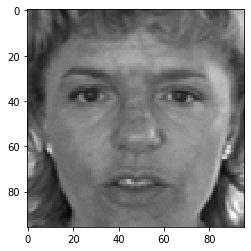

In [ ]:
plt.imshow(x[0,:,:,0].numpy(), cmap='gray')

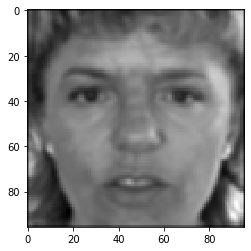

In [ ]:
plt.imshow(blurred_train[0,:,:,0].numpy(), cmap='gray')

In [ ]:
tf.ones(3) == 1

<tf.Tensor: id=109, shape=(3,), dtype=bool, numpy=array([ True,  True,  True])>

In [ ]:
@tf.function
def blurred_image(x,y):
  batch_size = tf.shape(x)[0]
    
  # set random tensor of 0s and 1s for records to flip
  uniform_random = tf.round(tf.random.uniform([batch_size], 0, 1.0, seed=None)) == 1
  #uniform_random = tf.ones(batch_size) == 0

  gauss_kernel = gaussian_kernel(2,0,1)

  # Expand dimensions of `gauss_kernel` for `tf.nn.conv2d` signature.
  gauss_kernel = gauss_kernel[:, :, tf.newaxis, tf.newaxis]

  blurred = tf.nn.conv2d(x[uniform_random], gauss_kernel, strides=[1, 1, 1, 1], padding="SAME")
  original = x[~uniform_random]

  # Convolve.
  out_train = tf.concat( (original, blurred), axis=0)


  #blurred_train = np.concatenate([cv2.blur(x[i,:,:,0], (2,2)).reshape(1,96,96,1) if uniform_random[i] else x[i] for i in range(batch_size)])
  return out_train, tf.concat((y[~uniform_random], y[uniform_random]), axis=0), 

def train_input_fn_blurred_map():
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X3d_train, y3_train))
    
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(B_S, drop_remainder=True)
    dataset = dataset.map(blurred_image)
    dataset = dataset.prefetch(-1)

    # Return the dataset.
    return dataset

In [ ]:
y3_train.shape

NameError: ignored

In [ ]:
xx, yy = blurred_image(x, y3_train[:5])
plt.imshow(xx[0,:,:,0].numpy(), cmap='gray')

In [ ]:
plt.imshow(x[1,:,:,0], cmap='gray')

In [ ]:
print(y3_train[1], yy[0])

In [ ]:
tf.keras.backend.clear_session()

with tpu_strategy.scope():  
    model = get_model2()
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=.001, momentum=0.99, nesterov=True),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    #model.summary()
B_S = 32
fitted_blurred = model.fit(train_input_fn_blurred_map(), epochs=500, verbose=0,
                   validation_data=val_input_fn_blurred(),
                   validation_steps=1,
                   steps_per_epoch=-(1712//-(B_S)))

NameError: ignored

In [ ]:
plt.plot(fitted2.history['loss'][:], label='original_train')
plt.plot(fitted2.history['val_loss'][:], label='original_valid')
plt.plot(fitted_blurred.history['loss'][:], label='blurred_train')
plt.plot(fitted_blurred.history['val_loss'][:], label='blurred_valid')
plt.plot(fitted_blurred_old.history['loss'][10:], label='blurred_train_old')
plt.plot(fitted_blurred_old.history['val_loss'][10:], label='blurred_valid_old')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()